In [ ]:
pip install qiskit qiskit_aer



---

# Imports

---



In [2]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import *
from numpy import pi
import numpy as np
import math
from qiskit_aer import Aer
from qiskit import transpile
import qiskit.quantum_info as qi
import random
from qiskit.circuit.library import SdgGate
import matplotlib.pyplot as plt



---

# Variable Definition

---



In [63]:
length=16
DitSequence= [random.randint(0, 3) for _ in range(length)]
AliceBases =[random.randint(0, 1) for _ in range(length)]
BobBases = [random.randint(0, 1) for _ in range(length)]
EveBases = [random.randint(0, 1) for _ in range(length)]



---

# Qudit Object

---



In [30]:
# All Qudit related functions and objects

def base4_sort(key):
    return int(key, 4)
class QuditCircuit:
    def __init__(self, d, n):
        # Calculate the total number of qubits
        self.num_qudits = n
        self.dimension = d
        self.num_qubits = n * d/2
        self.Counts = []
        self.Counts2 = []
        # Create a QuantumCircuit object with the specified dimensions
        self.circuit = QuantumCircuit(self.num_qubits, self.num_qubits)
    def measure(self):
        # Add a barrier to separate the measurement operations
        self.circuit.barrier()
        # Measure all qubits
        qubit_indices = list(range(int(self.num_qubits)))
        self.circuit.measure(qubit_indices, qubit_indices)
    def CT(self,Gate):
      CT_Gate = qi.Operator(Gate)
      for i in range(0, int(self.num_qubits), 2):
        self.circuit.unitary(CT_Gate, [i,i+1], label="CrossTalk")
    def Translate(self):
      # Translate each key into the desired format
      translated_data = {}
      for key, value in self.Counts.items():
          translated_key = ''.join([str(int(key[i:i+2], 2)) for i in range(0, len(key), 2)])
          translated_data[translated_key] = value
      sorted_data = {k: v for k, v in sorted(translated_data.items(), key=lambda item: base4_sort(item[0]))}
      self.Counts2 = sorted_data
    def run(self):
      # Use Aer's qasm_simulator
      simulator = Aer.get_backend('qasm_simulator')
      # Execute the circuit on the qasm simulator
      new_circuit = transpile(self.circuit, simulator)
      job = simulator.run(new_circuit, shots = 1)
      # Grab results from the job
      result = job.result()
      # Return counts
      self.Counts = result.get_counts(self.circuit)
      self.Translate()
    def test(self):
      self.circuit.x(1)



---

# BB84 functions

---



In [38]:
# Here are all the functions related to BB84 protocol

def Modulation(Qudit,Dit,AliceBasis):
  if AliceBasis == 0:
    #print("Basis 0")
    if Dit == 1:
      Qudit.circuit.x(0)
    if Dit == 2:
      Qudit.circuit.x(1)
    if Dit == 3:
      Qudit.circuit.x(0)
      Qudit.circuit.x(1)
  else:
     #print("Basis 1")
     if Dit == 0:
      #print("Entered 0")
      Qudit.circuit.h(0)
      Qudit.circuit.h(1)
     elif Dit == 1:
      #print("Entered 1")
      Qudit.circuit.x(1)
      Qudit.circuit.h(1)
      Qudit.circuit.h(0)
      Qudit.circuit.s(0)
     elif Dit == 2:
      #print("Entered 2")
      Qudit.circuit.x(0)
      Qudit.circuit.h(0)
      Qudit.circuit.h(1)
     elif Dit == 3:
      #print("Entered 3")
      Qudit.circuit.x(0)
      Qudit.circuit.h(0)
      Qudit.circuit.s(0)
      Qudit.circuit.x(1)
      Qudit.circuit.h(1)
  return Qudit
def ReciviengSinglePhoton(Qudit,BobBasis):
  csgate = SdgGate().control(1) # the parameter is the amount of control points you want
  if BobBasis == 1:
     #print("Measure Basis 1")
     Qudit.circuit.h(1)
     Qudit.circuit.append(csgate, [1, 0])
     Qudit.circuit.h(0)
     Qudit.circuit.cx(1,0)
     Qudit.circuit.cx(0,1)
     Qudit.circuit.cx(1,0)
  Qudit.measure()
  Qudit.run()
  #print(Qudit.Counts)
def CrossTalk(Qudit):
  Gate = [[0.9,math.sqrt(19/100)*1j,0,0],
        [math.sqrt(19/100)*1j,0.9,0,0],
        [0,0,0.9,math.sqrt(19/100)*1j],
        [0,0,math.sqrt(19/100)*1j,0.9]]
  Qudit.CT(Gate)
def BB84(DitSequence,AliceBases,BobBases,EveBases,length,Eve,CrossT):
   EveListOfCounts = []
   if Eve==True:
    for i in range(length):
        #print("for bit number : ", i)
        Qudit = QuditCircuit(4,1)
        #Getting that one photon with Alice's Basis ready to send
        Qudit = Modulation(Qudit,DitSequence[i],AliceBases[i])
        #circuit = GettingReady(circuit,BitSequence[i],AliceBases[i])
        #Sending Single photon
        CrossTalk(Qudit) if CrossT else None
        #Recive Single Photon
        ReciviengSinglePhoton(Qudit,EveBases[i])
        #Measure one Photon with Bob Basis
        EveListOfCounts.append(Qudit.Counts2)
    output_string = ""
    for d in EveListOfCounts:
     key = list(d.keys())[0]  # Extract the key from the dictionary
     output_string += key
    list_from_Key = [int(char) for char in output_string]
    ListOfCounts = []
    for i in range(length):
        #print("for bit number : ", i)
        Qudit = QuditCircuit(4,1)
        #Getting that one photon with Alice's Basis ready to send
        Qudit = Modulation(Qudit,DitSequence[i],EveBases[i])
        #circuit = GettingReady(circuit,BitSequence[i],AliceBases[i])
        #Sending Single photon
        CrossTalk(Qudit) if CrossT else None
        #Recive Single Photon
        ReciviengSinglePhoton(Qudit,BobBases[i])
        #Measure one Photon with Bob Basis
        ListOfCounts.append(Qudit.Counts2)
        #print("-----------")
    Check_list = []
    EveCheck_list = []
    for i in range(len(ListOfCounts)):
       if AliceBases[i] == BobBases[i]:
           Check_list.append(ListOfCounts[i])
           EveCheck_list.append(EveListOfCounts[i])
    #print("The Bases checked list is : ",Check_list)
    output_string = ""
    Eveoutput_string = ""
    for d in Check_list:
     key = list(d.keys())[0]  # Extract the key from the dictionary
     output_string += key
    for d in EveCheck_list:
     key = list(d.keys())[0]  # Extract the key from the dictionary
     Eveoutput_string += key
    return output_string , Eveoutput_string
   else:
    ListOfCounts = []
    for i in range(length):
        #print("for bit number : ", i)
        Qudit = QuditCircuit(4,1)
        #Getting that one photon with Alice's Basis ready to send
        Qudit = Modulation(Qudit,DitSequence[i],AliceBases[i])
        #circuit = GettingReady(circuit,BitSequence[i],AliceBases[i])
        #Sending Single photon
        CrossTalk(Qudit) if CrossT else None
        #Recive Single Photon
        ReciviengSinglePhoton(Qudit,BobBases[i])
        #Measure one Photon with Bob Basis
        ListOfCounts.append(Qudit.Counts2)
        #print("-----------")
    Check_list = []
    for i in range(len(ListOfCounts)):
       if AliceBases[i] == BobBases[i]:
           Check_list.append(ListOfCounts[i])
   #print("The Bases checked list is : ",Check_list)
    output_string = ""
    for d in Check_list:
     key = list(d.keys())[0]  # Extract the key from the dictionary
     output_string += key
    return  output_string
def AliceKey(Dit,AliceBases,BobBases):
    Check_list = []
    for i in range(len(Dit)):
        if AliceBases[i] == BobBases[i]:
            Check_list.append(Dit[i])
        Key = ''
    for item in Check_list:
        Key = Key + str(item)
    return Key
def CheckSecurity(Key,Akey,Checklength):
    if Akey[-Checklength:] == Key[-Checklength:]:
        print("The Connection is Secure with the probability of:")
        print((1-((3/4)**Checklength))*100)
    else:
        print("The Connection is not Secure!")




---

# Basic results

---



In [64]:
Key = BB84(DitSequence,AliceBases,BobBases,EveBases,length,False,False)
Key2 , EveKey = BB84(DitSequence,AliceBases,BobBases,EveBases,length,True,False)
aliceKey= AliceKey(DitSequence,AliceBases,BobBases)

In [65]:
print("Bob's Key is: ",Key)
print("Alice's Key is : ",aliceKey)
print("Bob's Key is(Eve): ",Key2)

Bob's Key is:  130001302
Alice's Key is :  130001302
Bob's Key is(Eve):  133001302


In [66]:
num_errors = sum(bit1 != bit2 for bit1, bit2 in zip(Key2, aliceKey))
print(num_errors)

1


In [34]:
CheckSecurity(Key,aliceKey,30)

The Connection is Secure with the probability of:
99.98214179098301


In [35]:
print(len(Key))

38


In [36]:
print("Bob's Key is: ",Key)
print("Alice's Key is : ",aliceKey)
print("Bob's Key is(Eve): ",Key2)
print("Eve's Key is: ",EveKey)

Bob's Key is:  30002331030020022123332130313230211030
Alice's Key is :  30002331030020022123332130313230211030
Bob's Key is(Eve):  30022331301302022103310330312230012030
Eve's Key is:  30012331003330022113312230313230311030


In [37]:
CheckSecurity(Key2,EveKey,33)

The Connection is not Secure!




---

# Error Analyse

---



In [68]:
#This Functions are for analizing our results
def calculate_error_rate(results, AliceKeyS):
    error_rates = []
    sums = 0
    results_length = len(results)


    for i in range(results_length):
        result = results[i]
        alicekey = AliceKeyS[i]
        # Compare each character in the strings and count the number of differences
        num_errors = sum(bit1 != bit2 for bit1, bit2 in zip(result, alicekey))
        # Calculate the error rate
        key_length = len(alicekey)
        error_rate = num_errors / key_length
        sums = sums + error_rate
        error_rates.append(error_rate)

    return max(error_rates), min(error_rates) , sums/results_length

In [8]:
aliceKey= AliceKey(DitSequence,AliceBases,BobBases)
results = []
for _ in range(30):
   result = BB84(DitSequence,AliceBases,BobBases,EveBases,length,False,True) # Call the BB84 function
   results.append(result)
print(results)

['210102002000211102022111222222100', '210102002000211102022111222222100', '210102002000211102022111222222100', '210102002000211102022111222222100', '210102002000211102022111222222100', '210102002000211102022111222222100', '210102002000211102022111222222100', '210102002000211102022111222222100', '210102002000211102022111222222100', '210102002000211102022111222222100', '210102002000211102022111222222100', '210102002000211102022111222222100', '210102002000211102022111222222100', '210102002000211102022111222222100', '210102002000211102022111222222100', '210102002000211102022111222222100', '210102002000211102022111222222100', '210102002000211102022111222222100', '210102002000211102022111222222100', '210102002000211102022111222222100', '210102002000211102022111222222100', '210102002000211102022111222222100', '210102002000211102022111222222100', '210102002000211102022111222222100', '210102002000211102022111222222100', '210102002000211102022111222222100', '210102002000211102022111222222100', 



---

## Basic Error results

---



In [9]:

error_rates , average = calculate_error_rate(results, aliceKey)
print("Max Error rate:", error_rates)
print("Average of error : ", average)

Max Error rate: 0.36363636363636365
Average of error :  0.3636363636363635


In [ ]:
aliceKey= AliceKey(DitSequence,AliceBases,BobBases)
Everesults = []
for _ in range(10):
   result = BB84(DitSequence,AliceBases,BobBases,EveBases,length,True,False) # Call the BB84 function
   Everesults.append(result)

In [ ]:
EveError_rates , EveAverage = calculate_error_rate(Everesults, aliceKey)
print("Error rates:", EveError_rates)
print("Average of error : ", EveAverage)

Error rates: [0.2857142857142857, 0.2698412698412698, 0.30158730158730157, 0.3333333333333333, 0.2857142857142857, 0.3333333333333333, 0.31746031746031744, 0.36507936507936506, 0.3492063492063492, 0.30158730158730157]
Average of error :  0.3142857142857143




---

## Length change

---





---

### 16 Bit

---



In [47]:
length=16
DitSequence= [random.randint(0, 3) for _ in range(length)]
AliceBases =[random.randint(0, 1) for _ in range(length)]
BobBases = [random.randint(0, 1) for _ in range(length)]
EveBases = [random.randint(0, 1) for _ in range(length)]
aliceKey= AliceKey(DitSequence,AliceBases,BobBases)
CleanResults = []
ResultsWE = []
EveResults = []
CTResults = []
CTResultsWE = []
EveCTResults = []
for _ in range(10):
   # Without Eve and CrossTalk
   result = BB84(DitSequence,AliceBases,BobBases,EveBases,length,False,False)
   CleanResults.append(result)
   #With Eve Without CrossTalk
   resultWE, Everesult = BB84(DitSequence,AliceBases,BobBases,EveBases,length,True,False)
   ResultsWE.append(resultWE)
   EveResults.append(Everesult)
   #With CrossTalk Witout Eve
   CTresult = BB84(DitSequence,AliceBases,BobBases,EveBases,length,False,True)
   CTResults.append(CTresult)
   #With Eve and CrossTalk
   CTresultWE, EveCTresult = BB84(DitSequence,AliceBases,BobBases,EveBases,length,True,True)
   CTResultsWE.append(CTresultWE)
   EveCTResults.append(EveCTresult)
   CleanError_rates , CleanAverage = calculate_error_rate(CleanResults, aliceKey)
Error_ratesWE , AverageWE = calculate_error_rate(ResultsWE, aliceKey)
EveError_rates , EveAverage = calculate_error_rate(EveResults, aliceKey)
CTError_rates , CTAverage = calculate_error_rate(CTResults, aliceKey)
CTError_ratesWE , CTAverageWE = calculate_error_rate(CTResultsWE, aliceKey)
EveCTError_rates , EveCTAverage = calculate_error_rate(EveCTResults, aliceKey)
print("######Without Eve and CrossTalk######")
print("Max Error rate:", CleanError_rates)
print("Average of error : ", CleanAverage)
print("\n\n######With Eve Without CrossTalk######")
print("Max Error rate:", Error_ratesWE)
print("Average of error : ", AverageWE)
print("Eve's Max Error rate:", EveError_rates)
print("Eve's Average of error : ", EveAverage)
print("\n\n#####Without Eve With CrossTalk#######")
print("Max Error rate:", CTError_rates)
print("Average of error : ", CTAverage)
print("\n\n######With Eve and CrossTalk######")
print("Max Error rate:", CTError_ratesWE)
print("Average of error : ", CTAverageWE)
print("Eve'sMax Error rate:", EveCTError_rates)
print("Eve's Average of error : ", EveCTAverage)


######Without Eve and CrossTalk######
Max Error rate: 0.0
Average of error :  0.0


######With Eve Without CrossTalk######
Max Error rate: 0.6666666666666666
Average of error :  0.4888888888888888
Eve's Max Error rate: 0.6666666666666666
Eve's Average of error :  0.5444444444444444


#####Without Eve With CrossTalk#######
Max Error rate: 0.4444444444444444
Average of error :  0.13333333333333336


######With Eve and CrossTalk######
Max Error rate: 0.8888888888888888
Average of error :  0.5777777777777777
Eve'sMax Error rate: 0.7777777777777778
Eve's Average of error :  0.7




---

### 32 Bit

---



In [44]:
length=32
DitSequence= [random.randint(0, 3) for _ in range(length)]
AliceBases =[random.randint(0, 1) for _ in range(length)]
BobBases = [random.randint(0, 1) for _ in range(length)]
EveBases = [random.randint(0, 1) for _ in range(length)]
aliceKey= AliceKey(DitSequence,AliceBases,BobBases)
CleanResults = []
ResultsWE = []
EveResults = []
CTResults = []
CTResultsWE = []
EveCTResults = []
for _ in range(10):
   # Without Eve and CrossTalk
   result = BB84(DitSequence,AliceBases,BobBases,EveBases,length,False,False)
   CleanResults.append(result)
   #With Eve Without CrossTalk
   resultWE, Everesult = BB84(DitSequence,AliceBases,BobBases,EveBases,length,True,False)
   ResultsWE.append(resultWE)
   EveResults.append(Everesult)
   #With CrossTalk Witout Eve
   CTresult = BB84(DitSequence,AliceBases,BobBases,EveBases,length,False,True)
   CTResults.append(CTresult)
   #With Eve and CrossTalk
   CTresultWE, EveCTresult = BB84(DitSequence,AliceBases,BobBases,EveBases,length,True,True)
   CTResultsWE.append(CTresultWE)
   EveCTResults.append(EveCTresult)
   CleanError_rates , CleanAverage = calculate_error_rate(CleanResults, aliceKey)
Error_ratesWE , AverageWE = calculate_error_rate(ResultsWE, aliceKey)
EveError_rates , EveAverage = calculate_error_rate(EveResults, aliceKey)
CTError_rates , CTAverage = calculate_error_rate(CTResults, aliceKey)
CTError_ratesWE , CTAverageWE = calculate_error_rate(CTResultsWE, aliceKey)
EveCTError_rates , EveCTAverage = calculate_error_rate(EveCTResults, aliceKey)
print("######Without Eve and CrossTalk######")
print("Max Error rate:", CleanError_rates)
print("Average of error : ", CleanAverage)
print("\n\n######With Eve Without CrossTalk######")
print("Max Error rate:", Error_ratesWE)
print("Average of error : ", AverageWE)
print("Eve's Max Error rate:", EveError_rates)
print("Eve's Average of error : ", EveAverage)
print("\n\n#####Without Eve With CrossTalk#######")
print("Max Error rate:", CTError_rates)
print("Average of error : ", CTAverage)
print("\n\n######With Eve and CrossTalk######")
print("Max Error rate:", CTError_ratesWE)
print("Average of error : ", CTAverageWE)
print("Eve'sMax Error rate:", EveCTError_rates)
print("Eve's Average of error : ", EveCTAverage)


######Without Eve and CrossTalk######
Max Error rate: 0.0
Average of error :  0.0


######With Eve Without CrossTalk######
Max Error rate: 0.5882352941176471
Average of error :  0.4882352941176471
Eve's Max Error rate: 0.6470588235294118
Eve's Average of error :  0.5235294117647059


#####Without Eve With CrossTalk#######
Max Error rate: 0.23529411764705882
Average of error :  0.13529411764705884


######With Eve and CrossTalk######
Max Error rate: 0.7058823529411765
Average of error :  0.5411764705882353
Eve'sMax Error rate: 0.6470588235294118
Eve's Average of error :  0.5470588235294118




---

### 64 Bit


---



In [ ]:
length=64
DitSS = []
AliceBS =[]
BobBS=[]
EveBS=[]
AliceKeyS =[]
for i in range(100):
 DitSS.append([random.randint(0, 3) for _ in range(length)])
 AliceBS.append([random.randint(0, 1) for _ in range(length)])
 BobBS.append([random.randint(0, 1) for _ in range(length)])
 EveBS.append([random.randint(0, 1) for _ in range(length)])
 AliceKeyS.append(AliceKey(DitSS[i],AliceBS[i],BobBS[i]))
CleanResults = []
ResultsWE = []
EveResults = []
CTResults = []
CTResultsWE = []
EveCTResults = []
for i in range(100):
   # Without Eve and CrossTalk
   result = BB84(DitSS[i],AliceBS[i],BobBS[i],EveBS[i],length,False,False)
   CleanResults.append(result)
   #With Eve Without CrossTalk
   resultWE, Everesult = BB84(DitSS[i],AliceBS[i],BobBS[i],EveBS[i],length,True,False)
   ResultsWE.append(resultWE)
   EveResults.append(Everesult)
   #With CrossTalk Witout Eve
   CTresult = BB84(DitSS[i],AliceBS[i],BobBS[i],EveBS[i],length,False,True)
   CTResults.append(CTresult)
   #With Eve and CrossTalk
   CTresultWE, EveCTresult = BB84(DitSS[i],AliceBS[i],BobBS[i],EveBS[i],length,True,True)
   CTResultsWE.append(CTresultWE)
   EveCTResults.append(EveCTresult)




In [69]:
CleanError_rates ,CleanMin, CleanAverage = calculate_error_rate(CleanResults, AliceKeyS)
Error_ratesWE ,MinWE, AverageWE = calculate_error_rate(ResultsWE,AliceKeyS )
EveError_rates ,EveMin, EveAverage = calculate_error_rate(EveResults, AliceKeyS)
CTError_rates , CTMin,CTAverage = calculate_error_rate(CTResults, AliceKeyS)
CTError_ratesWE , CTMinWE,CTAverageWE = calculate_error_rate(CTResultsWE,AliceKeyS)
EveCTError_rates , EveCTMin,EveCTAverage = calculate_error_rate(EveCTResults,AliceKeyS)
print("######Without Eve and CrossTalk######")
print("Max Error rate:", CleanError_rates)
print("Min Error rate:", CleanMin)
print("Average of error : ", CleanAverage)
print("\n\n######With Eve Without CrossTalk######")
print("Max Error rate:", Error_ratesWE)
print("Min Error rate:", MinWE)
print("Average of error : ", AverageWE)
print("Eve's Max Error rate:", EveError_rates)
print("Eve's Min Error rate:", EveMin)
print("Eve's Average of error : ", EveAverage)
print("\n\n#####Without Eve With CrossTalk#######")
print("Max Error rate:", CTError_rates)
print("Min Error rate:", CTMin)
print("Average of error : ", CTAverage)
print("\n\n######With Eve and CrossTalk######")
print("Max Error rate:", CTError_ratesWE)
print("Min Error rate:", CTMinWE)
print("Average of error : ", CTAverageWE)
print("Eve'sMax Error rate:", EveCTError_rates)
print("Eve's Min Error rate:", CleanMin)
print("Eve's Average of error : ", EveCTAverage)

######Without Eve and CrossTalk######
Max Error rate: 0.0
Min Error rate: 0.0
Average of error :  0.0


######With Eve Without CrossTalk######
Max Error rate: 0.6285714285714286
Min Error rate: 0.14285714285714285
Average of error :  0.3809400164147009
Eve's Max Error rate: 0.5714285714285714
Eve's Min Error rate: 0.25
Eve's Average of error :  0.39109044719379293


#####Without Eve With CrossTalk#######
Max Error rate: 0.3142857142857143
Min Error rate: 0.0
Average of error :  0.14534804086920894


######With Eve and CrossTalk######
Max Error rate: 0.6551724137931034
Min Error rate: 0.27586206896551724
Average of error :  0.45933256076776713
Eve'sMax Error rate: 0.6285714285714286
Eve's Min Error rate: 0.0
Eve's Average of error :  0.43038109557166243




---

### 128 Bit

---



In [46]:
length=128
DitSequence= [random.randint(0, 3) for _ in range(length)]
AliceBases =[random.randint(0, 1) for _ in range(length)]
BobBases = [random.randint(0, 1) for _ in range(length)]
EveBases = [random.randint(0, 1) for _ in range(length)]
aliceKey= AliceKey(DitSequence,AliceBases,BobBases)
CleanResults = []
ResultsWE = []
EveResults = []
CTResults = []
CTResultsWE = []
EveCTResults = []
for _ in range(10):
   # Without Eve and CrossTalk
   result = BB84(DitSequence,AliceBases,BobBases,EveBases,length,False,False)
   CleanResults.append(result)
   #With Eve Without CrossTalk
   resultWE, Everesult = BB84(DitSequence,AliceBases,BobBases,EveBases,length,True,False)
   ResultsWE.append(resultWE)
   EveResults.append(Everesult)
   #With CrossTalk Witout Eve
   CTresult = BB84(DitSequence,AliceBases,BobBases,EveBases,length,False,True)
   CTResults.append(CTresult)
   #With Eve and CrossTalk
   CTresultWE, EveCTresult = BB84(DitSequence,AliceBases,BobBases,EveBases,length,True,True)
   CTResultsWE.append(CTresultWE)
   EveCTResults.append(EveCTresult)
   CleanError_rates , CleanAverage = calculate_error_rate(CleanResults, aliceKey)
Error_ratesWE , AverageWE = calculate_error_rate(ResultsWE, aliceKey)
EveError_rates , EveAverage = calculate_error_rate(EveResults, aliceKey)
CTError_rates , CTAverage = calculate_error_rate(CTResults, aliceKey)
CTError_ratesWE , CTAverageWE = calculate_error_rate(CTResultsWE, aliceKey)
EveCTError_rates , EveCTAverage = calculate_error_rate(EveCTResults, aliceKey)
print("######Without Eve and CrossTalk######")
print("Max Error rate:", CleanError_rates)
print("Average of error : ", CleanAverage)
print("\n\n######With Eve Without CrossTalk######")
print("Max Error rate:", Error_ratesWE)
print("Average of error : ", AverageWE)
print("Eve's Max Error rate:", EveError_rates)
print("Eve's Average of error : ", EveAverage)
print("\n\n#####Without Eve With CrossTalk#######")
print("Max Error rate:", CTError_rates)
print("Average of error : ", CTAverage)
print("\n\n######With Eve and CrossTalk######")
print("Max Error rate:", CTError_ratesWE)
print("Average of error : ", CTAverageWE)
print("Eve'sMax Error rate:", EveCTError_rates)
print("Eve's Average of error : ", EveCTAverage)


######Without Eve and CrossTalk######
Max Error rate: 0.0
Average of error :  0.0


######With Eve Without CrossTalk######
Max Error rate: 0.38596491228070173
Average of error :  0.3385964912280702
Eve's Max Error rate: 0.42105263157894735
Eve's Average of error :  0.3385964912280702


#####Without Eve With CrossTalk#######
Max Error rate: 0.15789473684210525
Average of error :  0.13157894736842107


######With Eve and CrossTalk######
Max Error rate: 0.5087719298245614
Average of error :  0.41052631578947363
Eve'sMax Error rate: 0.47368421052631576
Eve's Average of error :  0.3929824561403509




---

# This Section is for Heat maps

(for running this part set the shots to 1000)

---



In [ ]:
def State_Probabilty_Visualization(CrossT):
  ListOfCounts = []
  Dits = [0,1,2,3]
  SenderBasis = [0,1]
  ReciverBasis = [0,1]
  for SBasis in SenderBasis:
    for  Dit in Dits:
      for RBasis in ReciverBasis:
        Qudit = QuditCircuit(4,1)
        Qudit = Modulation(Qudit,Dit,SBasis)
        CrossTalk(Qudit) if CrossT else None
        ReciviengSinglePhoton(Qudit,RBasis)
        counts = Qudit.Counts2
        for key in counts:
          counts[key] /= 1000
        for NDit in Dits:
          if str(NDit) not in counts:
            counts[str(NDit)] = 0.0
        ListOfCounts.append(counts)
  propmatrix = np.zeros((8,8))
  j = 0
  k = 0
  for i in ListOfCounts:
    propmatrix[k,j]= i['0']
    propmatrix[k,j+1] = i['1']
    propmatrix[k,j+2]= i['2']
    propmatrix[k,j+3] = i['3']
    j += 4
    if j >= 8 :
      j = 0
      k += 1
  return propmatrix

In [ ]:
propmat = State_Probabilty_Visualization(False)
propmat2 = State_Probabilty_Visualization(True)

In [ ]:
print("Without CrossTalk : \n",propmat,"\n\n################\n\nWith CrossTalk :\n",propmat2)

Without CrossTalk : 
 [[1.    0.    0.    0.    0.257 0.247 0.218 0.278]
 [0.    1.    0.    0.    0.243 0.243 0.245 0.269]
 [0.    0.    1.    0.    0.236 0.245 0.259 0.26 ]
 [0.    0.    0.    1.    0.226 0.262 0.266 0.246]
 [0.27  0.246 0.238 0.246 1.    0.    0.    0.   ]
 [0.261 0.24  0.254 0.245 0.    1.    0.    0.   ]
 [0.25  0.255 0.234 0.261 0.    0.    1.    0.   ]
 [0.285 0.251 0.219 0.245 0.    0.    0.    1.   ]] 

################

With CrossTalk :
 [[0.813 0.187 0.    0.    0.259 0.438 0.245 0.058]
 [0.193 0.807 0.    0.    0.246 0.057 0.269 0.428]
 [0.    0.    0.805 0.195 0.287 0.427 0.233 0.053]
 [0.    0.    0.201 0.799 0.264 0.044 0.257 0.435]
 [0.238 0.26  0.24  0.262 1.    0.    0.    0.   ]
 [0.055 0.431 0.057 0.457 0.    0.803 0.    0.197]
 [0.26  0.247 0.249 0.244 0.    0.    1.    0.   ]
 [0.448 0.063 0.435 0.054 0.    0.198 0.    0.802]]


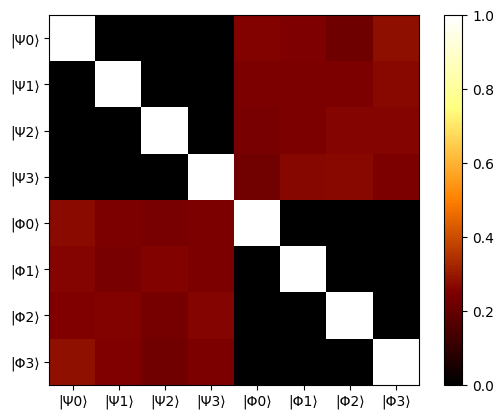

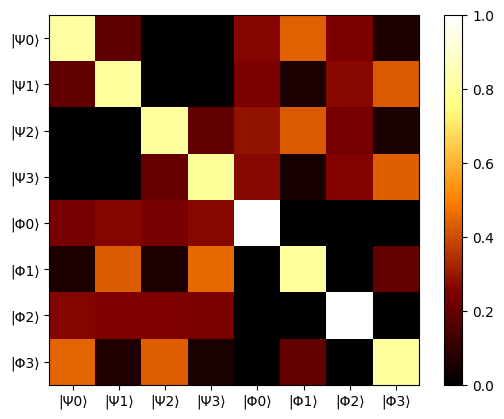

In [ ]:
# Plot the heatmap
plt.imshow(propmat, cmap='afmhot', interpolation='nearest')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7], labels=["|Ψ0⟩", "|Ψ1⟩", "|Ψ2⟩", "|Ψ3⟩" ,"|Φ0⟩", "|Φ1⟩","|Φ2⟩", "|Φ3⟩"])
plt.yticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7], labels=["|Ψ0⟩", "|Ψ1⟩", "|Ψ2⟩", "|Ψ3⟩" ,"|Φ0⟩", "|Φ1⟩","|Φ2⟩", "|Φ3⟩"])
# Add color bar
plt.colorbar()

# Show the plot
plt.show()
# Plot the heatmap
plt.imshow(propmat2, cmap='afmhot', interpolation='nearest')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7], labels=["|Ψ0⟩", "|Ψ1⟩", "|Ψ2⟩", "|Ψ3⟩" ,"|Φ0⟩", "|Φ1⟩","|Φ2⟩", "|Φ3⟩"])
plt.yticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7], labels=["|Ψ0⟩", "|Ψ1⟩", "|Ψ2⟩", "|Ψ3⟩" ,"|Φ0⟩", "|Φ1⟩","|Φ2⟩", "|Φ3⟩"])
# Add color bar
plt.colorbar()

# Show the plot
plt.show()



---


# Debug and Test Section
---



In [ ]:
circuit =  QuantumCircuit(2,2)
circuit.x(1)
circuit.h(1)
circuit.x(0)
circuit.h(0)
circuit.s(0)
# ---- MEAsure
csgate = SdgGate().control(1)
circuit.h(1)
circuit.append(csgate, [1, 0])
circuit.h(0)
circuit.cx(1,0)
circuit.cx(0,1)
circuit.cx(1,0)
circuit.measure([0,1], [0,1])
simulator = Aer.get_backend('qasm_simulator')
# Execute the circuit on the qasm simulator
new_circuit = transpile(circuit, simulator)
job = simulator.run(new_circuit, shots = 1000)
# Grab results from the job
result = job.result()
# Return count
Counts = result.get_counts(circuit)

In [ ]:
print(Counts)

{'11': 1000}
